In [6]:
import spacy
import xml.etree.ElementTree as ET
from spacy.symbols import nsubj, dobj, pobj, iobj, neg, xcomp, ccomp, VERB
from gensim.parsing.preprocessing import strip_multiple_whitespaces
import pandas as pd
import re
import os
import sys

def read_lines(inputparsed):    
    """takes input from CoreNLP sentence parsed file and returns sentences"""
    #parse all lines from CoreNLP sentence split
    parsed = open(inputparsed, encoding = "utf-8")
    parsedfile = parsed.readlines()
    parsedlines = []

    #Only keep those lines which have Sentence #n in the line before
    for idx, text in enumerate(parsedfile):
        if text.startswith("Sentence #"):
            parsedlines.append(parsedfile[idx+1].replace('\n','').strip())
    
    return parsedlines

def gen_poss(line, verb_match, pre_dict):
    """generates all possibilities of patterns that a multi word line implies,
    by extracting partial patterns and resolving placeholder words"""
    poss = []

    #replace special tokens in text that are clear at this point
    line = line.replace("*", verb_match)
    line = line.replace("- ", "")
    line = line.replace("+","")
    line = line.replace("%","")
    line = line.replace("^","")
    line = line.replace("$","")

    #split line by possibility indicators and code (always ends possibility)
    #example.: "- $ * (P ON KILLING (P OF + [010] #  COMMENT <ELH 07 May 2008>"
    poss_split = re.split("\(P |\[.*]",line) 

    if len(poss_split) > 2: #2 is if no (P in the line
        #only combining the first (P, as they share the same code 
        #and the longer version will never be contained in a text if the shorter isnt
        poss.append(strip_multiple_whitespaces(" ".join(poss_split[:2])).lower().rstrip().lstrip())
    else: 
        poss.append(strip_multiple_whitespaces(poss_split[0].lower().rstrip().lstrip()))

    cleaned = []
    for text in list(set(poss)):
        c = 0
        for tag in list(pre_dict.keys()):
            if tag in text:
                for replacement in pre_dict[tag]:
                    cleaned.append(text.replace(tag, replacement))
                    c += 1
        if c == 0:
            cleaned.append(text)

    return cleaned
    

def verb_code_dict(pico_path, verb_path):
    """reads coding ontology and verb lists, 
    directly matches verbs to their CAMEO codes and returns this verbs:codes dictionairy.
    verb with codes that cannot be read are printed out as full line of the file"""
    #read PETRARCH Internal Coding Ontology (= pico)
    pico_path = os.path.join(os.getcwd(), pico_path)
    pico_file = open(pico_path, 'r')
    pico_lines = pico_file.readlines()

    #get all 20 codes with their respective code
    main_codes = {}                             #we run one iteration for all the main codes, only main codes contain relation name
    for line in pico_lines:
        line = line.split('#')
        if line[0] == "" or line[0] == "\n":    #only intro comments and empty lines
            continue
        else: 
            code_split = line[0].split(":")     #splits into CAMEO code and related hex
            if len(line) > 1 and code_split[0][2] == "0":      #only main categories have 0 in 3rd idx, [cat_num 0] -> [010]
                main_codes[code_split[0][:2]] = line[-1].replace("\n","")
    
    #map code to code we want to use in the training
    map_codes = {"DiplomaticCoop" : "Engage In Diplomatic Cooperation", 
                "MaterialCoop" : "Engage In Material Cooperation",
                "ProvideAid" : "Provide Aid",
                "Intend" : "Express Intend to Cooperate",
                "Exhibit Force Posture": "Exhibit Military Posture",
                "Use Unconventional Mass Violence" : "Engage In Unconventional Mass Violence"}
    main_codes = {k: (map_codes[v] if v in map_codes else v) for k, v in main_codes.items()}
    
    #read single word patterns and match their code to the relation extracted in main_codes
    verb_path = os.path.join(os.getcwd(), verb_path)
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()
    
    verb_dict = {}
    for line in verb_lines:
        if line[0] == "#":
            continue
        elif line.startswith("---"):    #main verbs have a lead code, which is applied to all very in the section
                                        #unless a separate code is specified for a specific verb in section
            try: cur_main_code = re.split("\[|\]|---", line)[2].replace(":","")[:2]  #we only need main codes which are first two numbers
                                                                                #sometimes code starts with ":", e.g.: ---  OFFEND   [:110]  ---
                                                                                #we just remove those to get the main code
            except:                     #depending on chosen verb dictionairy, there may be main verbs without lead codes
                print("couldn't finde code in: ", line.replace("\n","")) 
                cur_main_code == "--"
            if cur_main_code == "": cur_main_code = "--"
        elif line == "\n":              #skip empty lines
            continue
        elif line[0] == "-" or line[0] == "~" or line[0] == "+" or line[0] == "&": #removes all special structures we cannot use
            continue
        else:
            if len(re.split("\[|\]", line)) > 1:    #verbs with their own code, e.g.: AFFIRM [051] 
                code = re.split("\[|\]", line)[1].replace(":","")[:2]
                if code != "--":
                    if "{" in line:         #conjugated verbs, e.g. "APPLY {APPLYING APPLIED APPLIES } [020]"
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower()] = main_codes[code] 
                        for word in line_s[1].split():
                            verb_dict[word.lower()] = main_codes[code]
                    else:
                        word = re.split("\[|\]", line)[0]
                        verb_dict[word.lower()] = main_codes[code]
            else:
                if cur_main_code != "--":
                    if "{" in line:         #e.g. "HURRY {HURRIES HURRYING HURRIED }" 
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower()] = main_codes[cur_main_code]
                        for word in line_s[1].split():
                            verb_dict[word.lower()] = main_codes[cur_main_code]
                    else:                   #only single words with sometimes comments, e.g.: CENSURE  # JON 5/17/95
                        word = line.split("#")[0].rstrip()    #gets part before "#", removes all whitespaces to the right
                        verb_dict[word.lower()] = main_codes[cur_main_code]

    #read multi word patterns and create a dictionary for their code

    #get filler words that occur in multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    pre_dict = {}
    filter_list = []
    for line in verb_lines:
        if line.startswith("&"):
            cur_filter = line.rstrip()
        elif line.startswith("\n") and "cur_filter" in locals():
            pre_dict[cur_filter.lower()] = filter_list
            cur_filter = ""
            filter_list = []
        elif line.startswith("+") and cur_filter != "":
            filter_list.append(line.rstrip()[1:].replace("_", "").lower())
    del pre_dict[""]

    #generate dictionaries for multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    spec_dict = {}
    spec_code = {}

    count = 0
    for line in verb_lines:
        if line.startswith("- "):
            #get main verb as dict key
            try: 
                verb_match = re.search("# *\w+", line).group()
                verb_match = re.search("\w+", verb_match).group()
                verb_match = verb_match.replace("_", " ").lower()
            except: 
                count += 1

            #get code for line
            try:
                code = re.search("\[.*]", line).group()[1:3]
                if code != "--":
                    #get all possibility that the line indicates
                    poss = gen_poss(line, verb_match, pre_dict)
                    for pattern in poss:
                        spec_code[pattern] = main_codes[code]
                    spec_dict[verb_match] = poss
            except:
                count += 1

    print(f"{count} patterns could not be loaded")        

    return verb_dict, spec_dict, spec_code


def get_triples(sentence, verb_dict, spec_dict, spec_code, nlp):
    """create triplet structure for training from text input, 
    verb_dict needs to be loaded before,
    spacy model needs to be initialized before """
    doc = nlp(sentence)
    verbs = []
    dict = {}


    for possible_verb in doc:
        if possible_verb.pos == VERB:
            if neg in [child.dep for child in possible_verb.children]: continue
            else: 
                for possible_subject in possible_verb.children: 
                    if possible_subject.dep == xcomp or possible_subject.dep == ccomp: 
                        main_verb = possible_subject
                        main_idx = possible_subject.idx
                        for token in doc.ents:
                            if token.label_ in ["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]:
                                if token.root.dep_ == "poss" or token.root.dep_ == "prep":
                                    if token.root.head.head.idx == possible_verb.idx:
                                        verbs.append([main_idx, main_verb.lemma_, token.text, token.root.head.dep_])
                                        if main_idx in dict.keys(): dict[main_idx] += 1
                                        else: dict[main_idx] = 1
                                else:
                                    if token.root.head.idx == possible_verb.idx:
                                        verbs.append([main_idx, main_verb.lemma_, token.text, token.root.dep_])
                                        if possible_verb.idx in dict.keys(): dict[possible_verb.idx] += 1
                                        else: dict[possible_verb.idx] = 1

                for token in doc.ents:
                    if token.label_ in ["GPE", "NORP", "EVENTS", "FAC", "LAW", "ORG", "PERSON"]:
                        if token.root.dep_ == "poss" or token.root.dep_ == "prep":
                            if token.root.head.head.idx == possible_verb.idx:
                                verbs.append([possible_verb.idx, possible_verb.lemma_, token.text, token.root.head.dep_])
                                if possible_verb.idx in dict.keys(): dict[possible_verb.idx] += 1
                                else: dict[possible_verb.idx] = 1
                        else:
                            if token.root.head.idx == possible_verb.idx:
                                verbs.append([possible_verb.idx, possible_verb.lemma_, token.text, token.root.dep_])
                                if possible_verb.idx in dict.keys(): dict[possible_verb.idx] += 1
                                else: dict[possible_verb.idx] = 1

    trip_idx = [key for key in dict if dict[key] > 1]

    # doc = nlp(sentence)
    # verbs = []
    # dict = {}

    # for possible_verb in doc:           #parses through all words in sentence
    #     if possible_verb.pos == VERB:   #we only care about verbs
    #         if neg in [child.dep for child in possible_verb.children]: continue #we exclude all negated verbs
    #         else: 
    #             for candidate in possible_verb.children: #for composed verbs of verb (e.g. "want to join" -> "want join")
    #                 if candidate.dep == xcomp:   #subj / obj of composed verb should also be subj / obj of main verb
    #                     main_verb = candidate    
    #                     main_idx = candidate.idx
    #                     for chunk in doc.noun_chunks:   #chunks are noun-groups (e.g.: "78 out of 100 people" instead of "people")
    #                         if chunk.root.head.idx == possible_verb.idx:    #if chunk applies to xcomp (want),
    #                                                                         #treat it like it aplles to main verb ("join")
    #                             verbs.append([main_idx, main_verb.lemma_, chunk.text, chunk.root.dep_])
    #                             if main_idx in dict.keys(): dict[main_idx] += 1 #count how often verb is used
    #                             else: dict[main_idx] = 1

    #             for chunk in doc.noun_chunks:       #for normal verbs, check chunks directly
    #                 if chunk.root.head.idx == possible_verb.idx:
    #                     verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])
    #                     if possible_verb.idx in dict.keys(): dict[possible_verb.idx] += 1
    #                     else: dict[possible_verb.idx] = 1
    
    # trip_idx = [key for key in dict if dict[key] > 1]   #if verbs used more than once, its candidate for triplet

    #priority for subj-relation-obj triplets
    mapper = {"nsubj":1,"dobj":2, "pobj":2, "iobj":2}

    #create df from verbs extracted 
    df = pd.DataFrame(verbs, columns = ["idx", "verb", "noun", "noun_type"])
    df["noun_map"] = df.noun_type.map(mapper)  #turn noun_types into priority 
    return df

    # #create groups that resolve around same word
    # gb = df.groupby('idx')    
    # #only keep groups if verb idx was identified as potential triplet before, sort by priority for structure
    # df_l = [gb.get_group(x).sort_values("noun_map") for x in gb.groups if gb.get_group(x).idx.iloc[0] in dict]
    # matches = [merge_trip(group) for group in df_l if not merge_trip(group) == None] #get groups into triplet structure
    
    # #turn matches into triples by only keeping those with coded verbs, return code instead of verb
    # triples = []
    # for match in matches:
    #     if match[1].lower() in spec_dict:
    #         for poss_pattern in spec_dict[match[1].lower()]:
    #             if set(poss_pattern.split()).intersection(sentence.split()) == set(poss_pattern.split()):
    #                 triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {spec_code[poss_pattern]}")
                    
    #     elif match[1].lower() in verb_dict:
    #         triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {verb_dict[match[1].lower()]}")
    #     else: print(f"couldn't match {match[1].lower()}")

    # #triples = [f"<triplet> {match[0]} <subj> {match[2]} <obj> {verb_dict[match[1].lower()]}" for match in matches if match[1].lower() in verb_dict]

    # return triples

def merge_trip(df):
    """helper function to turn two rows of a pandas groupby into subj, verb, obj"""
    if df.shape[0] == 2:
        if df.noun_type.iloc[0] != df.noun_type.iloc[1]:
            return [df.iloc[0].noun, df.iloc[0].verb, df.iloc[1].noun]
    elif df.shape[0] > 2:
        for i in range(df.shape[0] - 1):
            if df.noun_type.iloc[i] != df.noun_type.iloc[i+1]:
                return [df.iloc[0].noun, df.iloc[0].verb, df.iloc[1].noun]

    

In [7]:
pico_path = "src/add_labels/dictionaries/PETR.Internal.Coding.Ontology.txt"
verb_path = "src/add_labels/dictionaries/newdict.txt"

In [3]:
nlp = spacy.load('en_core_web_lg')
read = read_lines("data/out_data/articles_url_coref3.csv.xml.out")

FileNotFoundError: [Errno 2] No such file or directory: 'data/out_data/articles_url_coref3.csv.xml.out'

In [8]:
verb_dict, spec_dict, spec_code = verb_code_dict(pico_path, verb_path)

couldn't finde code in:  --- DEFEND  ###
couldn't finde code in:  --- REVOKE_   ###
couldn't finde code in:  --- SEND   ###
couldn't finde code in:  --- COLLAPSE  ###
22 patterns could not be loaded


In [9]:
verb_dict

{'abandon': 'Yield',
 'explain': 'Make Public Statement',
 'comment': 'Make Public Statement',
 'assert': 'Make Public Statement',
 'say  ': 'Make Public Statement',
 'says': 'Make Public Statement',
 'said': 'Make Public Statement',
 'saying': 'Make Public Statement',
 'clarify ': 'Make Public Statement',
 'clarifies': 'Make Public Statement',
 'clarified': 'Make Public Statement',
 'clarifying': 'Make Public Statement',
 'elucidate': 'Make Public Statement',
 'explicate': 'Make Public Statement',
 'rationalize': 'Make Public Statement',
 'express ': 'Make Public Statement',
 'articulate': 'Make Public Statement',
 'state': 'Make Public Statement',
 'tell ': 'Make Public Statement',
 'tells': 'Make Public Statement',
 'told': 'Make Public Statement',
 'telling': 'Make Public Statement',
 'narrate': 'Make Public Statement',
 'describe': 'Make Public Statement',
 'define': 'Make Public Statement',
 'depict': 'Make Public Statement',
 'detail': 'Make Public Statement',
 'expound': 'Make 

In [194]:
dfs_2 = [[sentence, get_triples(sentence, verb_dict, spec_dict, spec_code, nlp)] for sentence in read]

In [195]:
len(dfs_2)

21395

In [102]:
dfs_2[:5]

[['AdvertisingRead moreThis live page is no longer being updated.',
  Empty DataFrame
  Columns: [idx, verb, noun, noun_type, noun_map]
  Index: []],
 ['For more on\xa0our coverage of the war in Ukraine, click here.11:44pm:\xa0UN grain coordinator\xa0expects loaded ships to depart Ukraine on ThursdayThe UN coordinator for the Ukraine Black Sea grain deal said UN grain coordinator expects loaded ships to depart Ukrainian ports on ThursdayThe.',
     idx    verb     noun noun_type  noun_map
  0  113  depart  Ukraine      dobj         2],
 ['“Exports of grain and foodstuffs from Ukraine need to continue.',
  Empty DataFrame
  Columns: [idx, verb, noun, noun_type, noun_map]
  Index: []],
 ['Although no movements of vessels are planned for 2 November under the #BlackSeaGrainInitiative, we expect loaded ships to sail on ThursdayThe,” UN coordinator Amir Abdulla posted on Twitter.',
     idx  verb          noun noun_type  noun_map
  0  172  post  Amir Abdulla     nsubj         1],
 ['Exports 

In [103]:
dfs_2[13]

['The UN Secretariat at coordination centreThere reports that the Ukrainian, Turkish and UN delegations agreed not to plan any movement of vessels in the Black Sea Grain Initiative for 2 November," "The UN Secretariat at the Joint Coordination Centre said Tuesday, referring to the July deal brokered by Turkey and the UN.6:15pm:\xa0Russian President Vladimir Putin tells Erdogan Russian President Vladimir Putin wants \'real guarantees\' from Kyiv on grain deal, says Russian President Vladimir Putin told Erdogan Tuesday that Russian President Vladimir Putin wanted "real guarantees" from Kyiv before Kyiv potentially rejoined grain deal.',
    idx    verb                noun noun_type  noun_map
 0   47  report  The UN Secretariat     nsubj         1
 1  361    tell      Vladimir Putin     nsubj         1
 2  408    want      Vladimir Putin     nsubj         1
 3  495    tell      Vladimir Putin     nsubj         1
 4  495    tell             Erdogan      dobj         2
 5  554    want      

In [196]:
candidats_2 = [df for df in dfs_2 if df[1].shape[0] >= 2]

In [197]:
len(candidats_2)

8364

In [198]:
dfs_2[13][1]["idx"]

0     102
1      47
2     408
3     361
4     408
5     554
6     554
7     495
8     495
9     554
10    613
Name: idx, dtype: int64

In [199]:
trips_2 = []
for can in candidats_2:
    for idx in can[1]["idx"]:
        if can[1]["idx"].to_list().count(idx) > 1:
            trips_2.append([can[0], can[1]])
            break

In [200]:
len(trips_2)


3510

In [201]:
matches_2 = []
for idx, df in enumerate(trips_2):
    #create groups that resolve around same word
    gb = df[1].groupby('idx')  
    #only keep groups if verb idx was identified as potential triplet before, sort by priority for structure
    for x in gb.groups:
        group = gb.get_group(x).sort_values("noun_map")
        if group.shape[0] == 2:
            if group.noun_type.iloc[0] != group.noun_type.iloc[1]:
                matches_2.append([df[0], group.iloc[0].noun, group.iloc[0].verb, group.iloc[1].noun])
        elif group.shape[0] > 2:
            for i in range(group.shape[0] - 1):
                if group.noun_type.iloc[i] != group.noun_type.iloc[i+1]:
                    matches_2.append([df[0], group.iloc[0].noun, group.iloc[0].verb, group.iloc[1].noun])

In [202]:
triples_2 = []
ma_df = pd.DataFrame(matches_2, columns = ["text","subj", "verb","obj"])
for row in ma_df.iterrows():
    if row[1]["verb"] in spec_dict:
        for poss_pattern in spec_dict[row[1]["verb"]]:
            if set(poss_pattern.split()).intersection(row[1]["text"].split()) == set(poss_pattern.split()):
                triples_2.append([row[1]["text"], row[1]['subj'], row[1]['obj'] , spec_code[poss_pattern]])
    elif row[1]["verb"] in verb_dict:
            triples_2.append([row[1]["text"], row[1]['subj'], row[1]['obj'], verb_dict[row[1]['verb']]])

In [203]:
len(triples_2)

276

In [205]:
huh2 = pd.DataFrame(triples_2, columns = ["text", "subj", "obj", "label"])

In [206]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
probs_l = []
for row in huh2.iterrows():
    premise = row[1]["text"]
    subj = row[1]["subj"]
    rel = row[1]["label"]
    obj =  row[1]["obj"]

    hypothesis = f'{subj} does {rel} towards {obj}.'

    # run through model pre-trained on MNLI
    x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                        truncation_strategy='only_first')
    logits = nli_model(x)[0]

    # we throw away "neutral" (dim 1) and take the probability of
    # "entailment" (2) as the probability of the label being true 
    entail_contradiction_logits = logits[:,[0,2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:,1]

    probs_l.append([row[0], prob_label_is_true.item()])
    if row[0] % 100 == 0: print(row[0])

C:\Users\svawe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


0
100
200


In [207]:
ent = pd.merge(huh2.reset_index(), pd.DataFrame(probs_l, columns = ["index", "prob"]), on = "index")

In [208]:
ent.text.iloc[0]

'Russian President Vladimir Putin told Erdogan in a phone call that Russia sought "real guarantees from Kyiv about the strict observance of the Istanbul agreement, in particular about not using the humanitarian corridor for military purposes", according to a statement from the Kremlin.3:51pm: France says Russia endangering world food securityFrench President Emmanuel Macron on Tuesday accused Russia of endangering world food supplies by a unilateral decision by Russia which again harms global food security Russia\'s participation in a landmark Ukraine grain deal.Russia on Saturday halted Russia\'s participation in the agreement that allowed vital grain exports from Ukraine, blaming drone attacks on Russian ships in the Crimea.In a call with Ukrainian President Volodymyr Zelensky, securityFrench President Emmanuel Macron "the announcement a unilateral decision by Russia which again harms global food security", the president\'s office said.Russia made the announcement after Russia\'s arm

In [123]:
ent.iloc[1]

index                                                    1
text     10:23am: Three more ships leave Ukraine ports ...
subj                                               Finland
obj                                                 Turkey
label                                           Disapprove
prob                                              0.097846
Name: 1, dtype: object

In [209]:
ent[ent.prob > 0.5]

,index,text,subj,obj,label,prob
2,2,"""Those who intend to confront and subvert the ...",the Associated Press,Iran,Make Public Statement,0.599615
10,10,China have suggested to the Saudis that China ...,China,China,Engage In Material Cooperation,0.666303
17,17,"Maxim Dlugy said, ""Well, world champion Magnus...",Magnus Carlsen,Maxim Dlugy,Engage In Diplomatic Cooperation,0.829087
23,23,Can China Bring Vladimir Putin's To Vladimir P...,China,Vladimir Putin's,Consult,0.598665
24,24,Can China Bring Vladimir Putin's To Vladimir P...,China,Vladimir Putin's,Consult,0.598665
...,...,...,...,...,...,...
266,266,"In June, Alexander Nikulin - who worked at the...",Alexander Nikulin,Britons,Coerce,0.838175
268,268,(Fernando Vergara/Associated Press)Earlier thi...,Nicolas Maduro,Gustavo Petro,Disapprove,0.587277
269,269,"In June, Alexander Nikulin - who worked at the...",Alexander Nikulin,Britons,Coerce,0.838175
270,270,"'Jordan, AdvertisingRead moreJordan Bardella, ...",moreJordan Bardella,Jordan,Make Public Statement,0.524766


# Retrial with chunks instead of tokens

In [5]:
import spacy
import xml.etree.ElementTree as ET
from spacy.symbols import nsubj, dobj, pobj, iobj, neg, xcomp, VERB
from gensim.parsing.preprocessing import strip_multiple_whitespaces
import pandas as pd
import re
import os
import sys

def read_lines(inputparsed):    
    """takes input from CoreNLP sentence parsed file and returns sentences"""
    #parse all lines from CoreNLP sentence split
    parsed = open(inputparsed, encoding = "utf-8")
    parsedfile = parsed.readlines()
    parsedlines = []

    #Only keep those lines which have Sentence #n in the line before
    for idx, text in enumerate(parsedfile):
        if text.startswith("Sentence #"):
            parsedlines.append(parsedfile[idx+1].replace('\n','').strip())
    
    return parsedlines

def gen_poss(line, verb_match, pre_dict):
    """generates all possibilities of patterns that a multi word line implies,
    by extracting partial patterns and resolving placeholder words"""
    poss = []

    #replace special tokens in text that are clear at this point
    line = line.replace("*", verb_match)
    line = line.replace("- ", "")
    line = line.replace("+","")
    line = line.replace("%","")
    line = line.replace("^","")
    line = line.replace("$","")

    #split line by possibility indicators and code (always ends possibility)
    #example.: "- $ * (P ON KILLING (P OF + [010] #  COMMENT <ELH 07 May 2008>"
    poss_split = re.split("\(P |\[.*]",line) 

    if len(poss_split) > 2: #2 is if no (P in the line
        #only combining the first (P, as they share the same code 
        #and the longer version will never be contained in a text if the shorter isnt
        poss.append(strip_multiple_whitespaces(" ".join(poss_split[:2])).lower().rstrip().lstrip())
    else: 
        poss.append(strip_multiple_whitespaces(poss_split[0].lower().rstrip().lstrip()))

    cleaned = []
    for text in list(set(poss)):
        c = 0
        for tag in list(pre_dict.keys()):
            if tag in text:
                for replacement in pre_dict[tag]:
                    cleaned.append(text.replace(tag, replacement))
                    c += 1
        if c == 0:
            cleaned.append(text)

    return cleaned
    

def verb_code_dict(pico_path, verb_path):
    """reads coding ontology and verb lists, 
    directly matches verbs to their CAMEO codes and returns this verbs:codes dictionairy.
    verb with codes that cannot be read are printed out as full line of the file"""
    #read PETRARCH Internal Coding Ontology (= pico)
    pico_path = os.path.join(os.getcwd(), pico_path)
    pico_file = open(pico_path, 'r')
    pico_lines = pico_file.readlines()

    #get all 20 codes with their respective code
    main_codes = {}                             #we run one iteration for all the main codes, only main codes contain relation name
    for line in pico_lines:
        line = line.split('#')
        if line[0] == "" or line[0] == "\n":    #only intro comments and empty lines
            continue
        else: 
            code_split = line[0].split(":")     #splits into CAMEO code and related hex
            if len(line) > 1 and code_split[0][2] == "0":      #only main categories have 0 in 3rd idx, [cat_num 0] -> [010]
                main_codes[code_split[0][:2]] = line[-1].replace("\n","")
    
    #map code to code we want to use in the training
    map_codes = {"DiplomaticCoop" : "Engage In Diplomatic Cooperation", 
                "MaterialCoop" : "Engage In Material Cooperation",
                "ProvideAid" : "Provide Aid",
                "Exhibit Force Posture": "Exhibit Military Posture",
                "Use Unconventional Mass Violence" : "Engage In Unconventional Mass Violence"}
    main_codes = {k: (map_codes[v] if v in map_codes else v) for k, v in main_codes.items()}
    
    #read single word patterns and match their code to the relation extracted in main_codes
    verb_path = os.path.join(os.getcwd(), verb_path)
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()
    
    verb_dict = {}
    for line in verb_lines:
        if line[0] == "#":
            continue
        elif line.startswith("---"):    #main verbs have a lead code, which is applied to all very in the section
                                        #unless a separate code is specified for a specific verb in section
            try: cur_main_code = re.split("\[|\]|---", line)[2].replace(":","")[:2]  #we only need main codes which are first two numbers
                                                                                #sometimes code starts with ":", e.g.: ---  OFFEND   [:110]  ---
                                                                                #we just remove those to get the main code
            except:                     #depending on chosen verb dictionairy, there may be main verbs without lead codes
                print("couldn't finde code in: ", line.replace("\n","")) 
                cur_main_code == "--"
            if cur_main_code == "": cur_main_code = "--"
        elif line == "\n":              #skip empty lines
            continue
        elif line[0] == "-" or line[0] == "~" or line[0] == "+" or line[0] == "&": #removes all special structures we cannot use
            continue
        else:
            if len(re.split("\[|\]", line)) > 1:    #verbs with their own code, e.g.: AFFIRM [051] 
                code = re.split("\[|\]", line)[1].replace(":","")[:2]
                if code != "--":
                    if "{" in line:         #conjugated verbs, e.g. "APPLY {APPLYING APPLIED APPLIES } [020]"
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower()] = main_codes[code] 
                        for word in line_s[1].split():
                            verb_dict[word.lower()] = main_codes[code]
                    else:
                        word = re.split("\[|\]", line)[0]
                        verb_dict[word.lower()] = main_codes[code]
            else:
                if cur_main_code != "--":
                    if "{" in line:         #e.g. "HURRY {HURRIES HURRYING HURRIED }" 
                        line_s = re.split("\{|\}", line)    #split at { and }
                        verb_dict[line_s[0].lower()] = main_codes[cur_main_code]
                        for word in line_s[1].split():
                            verb_dict[word.lower()] = main_codes[cur_main_code]
                    else:                   #only single words with sometimes comments, e.g.: CENSURE  # JON 5/17/95
                        word = line.split("#")[0].rstrip()    #gets part before "#", removes all whitespaces to the right
                        verb_dict[word.lower()] = main_codes[cur_main_code]

    #read multi word patterns and create a dictionary for their code

    #get filler words that occur in multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    pre_dict = {}
    filter_list = []
    for line in verb_lines:
        if line.startswith("&"):
            cur_filter = line.rstrip()
        elif line.startswith("\n") and "cur_filter" in locals():
            pre_dict[cur_filter.lower()] = filter_list
            cur_filter = ""
            filter_list = []
        elif line.startswith("+") and cur_filter != "":
            filter_list.append(line.rstrip()[1:].replace("_", "").lower())
    del pre_dict[""]

    #generate dictionaries for multi word patterns
    verb_file = open(verb_path, 'r')
    verb_lines = verb_file.readlines()

    spec_dict = {}
    spec_code = {}

    count = 0
    for line in verb_lines:
        if line.startswith("- "):
            #get main verb as dict key
            try: 
                verb_match = re.search("# *\w+", line).group()
                verb_match = re.search("\w+", verb_match).group()
                verb_match = verb_match.replace("_", " ").lower()
            except: 
                count += 1

            #get code for line
            try:
                code = re.search("\[.*]", line).group()[1:3]
                if code != "--":
                    #get all possibility that the line indicates
                    poss = gen_poss(line, verb_match, pre_dict)
                    for pattern in poss:
                        spec_code[pattern] = main_codes[code]
                    spec_dict[verb_match] = poss
            except:
                count += 1

    print(f"{count} patterns could not be loaded")        

    return verb_dict, spec_dict, spec_code


def get_triples(sentence, verb_dict, spec_dict, spec_code, nlp):
    """create triplet structure for training from text input, 
    verb_dict needs to be loaded before,
    spacy model needs to be initialized before """
    doc = nlp(sentence)
    verbs = []
    dict = {}
    for possible_verb in doc:
        if possible_verb.pos == VERB:
            if neg in [child.dep for child in possible_verb.children]: continue
            else: 
                for possible_subject in possible_verb.children: 
                    if possible_subject.dep == xcomp or possible_subject.dep == ccomp:   #subj / obj of composed verb should also be subj / obj of main verb
                        main_verb = possible_subject
                        main_idx = possible_subject.idx
                        
                        for chunk in doc.noun_chunks:
                            if chunk.root.dep_ == "poss" or chunk.root.dep_ == "prep":
                                if chunk.root.head.head.idx == possible_verb.idx:
                                    verbs.append([main_idx, main_verb.lemma_, chunk.text, chunk.root.head.dep_])

                            else:
                                if chunk.root.head.idx == possible_verb.idx:
                                    verbs.append([main_idx, main_verb.lemma_, chunk.text, chunk.root.dep_])


                for chunk in doc.noun_chunks:       #for normal verbs, check chunks directly
                    if chunk.root.head.dep_ == "poss" or chunk.root.head.dep_ == "prep":
                        if chunk.root.head.head.idx == possible_verb.idx:
                            verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.head.dep_])

                    else:
                        if chunk.root.head.idx == possible_verb.idx:
                            verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])

    # doc = nlp(sentence)
    # verbs = []
    # dict = {}

    # for possible_verb in doc:           #parses through all words in sentence
    #     if possible_verb.pos == VERB:   #we only care about verbs
    #         if neg in [child.dep for child in possible_verb.children]: continue #we exclude all negated verbs
    #         else: 
    #             for candidate in possible_verb.children: #for composed verbs of verb (e.g. "want to join" -> "want join")
    #                 if candidate.dep == xcomp:   #subj / obj of composed verb should also be subj / obj of main verb
    #                     main_verb = candidate    
    #                     main_idx = candidate.idx
    #                     for chunk in doc.noun_chunks:   #chunks are noun-groups (e.g.: "78 out of 100 people" instead of "people")
    #                         if chunk.root.head.idx == possible_verb.idx:    #if chunk applies to xcomp (want),
    #                                                                         #treat it like it aplles to main verb ("join")
    #                             verbs.append([main_idx, main_verb.lemma_, chunk.text, chunk.root.dep_])
    #                             if main_idx in dict.keys(): dict[main_idx] += 1 #count how often verb is used
    #                             else: dict[main_idx] = 1

    #             for chunk in doc.noun_chunks:       #for normal verbs, check chunks directly
    #                 if chunk.root.head.idx == possible_verb.idx:
    #                     verbs.append([possible_verb.idx, possible_verb.lemma_, chunk.text, chunk.root.dep_])
    #                     if possible_verb.idx in dict.keys(): dict[possible_verb.idx] += 1
    #                     else: dict[possible_verb.idx] = 1
    
    # trip_idx = [key for key in dict if dict[key] > 1]   #if verbs used more than once, its candidate for triplet

    #priority for subj-relation-obj triplets
    mapper = {"nsubj":1,"dobj":2, "pobj":2, "iobj":2}

    #create df from verbs extracted 
    df = pd.DataFrame(verbs, columns = ["idx", "verb", "noun", "noun_type"])
    df["noun_map"] = df.noun_type.map(mapper)  #turn noun_types into priority 
    return df

    # #create groups that resolve around same word
    # gb = df.groupby('idx')    
    # #only keep groups if verb idx was identified as potential triplet before, sort by priority for structure
    # df_l = [gb.get_group(x).sort_values("noun_map") for x in gb.groups if gb.get_group(x).idx.iloc[0] in dict]
    # matches = [merge_trip(group) for group in df_l if not merge_trip(group) == None] #get groups into triplet structure
    
    # #turn matches into triples by only keeping those with coded verbs, return code instead of verb
    # triples = []
    # for match in matches:
    #     if match[1].lower() in spec_dict:
    #         for poss_pattern in spec_dict[match[1].lower()]:
    #             if set(poss_pattern.split()).intersection(sentence.split()) == set(poss_pattern.split()):
    #                 triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {spec_code[poss_pattern]}")
                    
    #     elif match[1].lower() in verb_dict:
    #         triples.append(f"<triplet> {match[0]} <subj> {match[2]} <obj> {verb_dict[match[1].lower()]}")
    #     else: print(f"couldn't match {match[1].lower()}")

    # #triples = [f"<triplet> {match[0]} <subj> {match[2]} <obj> {verb_dict[match[1].lower()]}" for match in matches if match[1].lower() in verb_dict]

    # return triples

def merge_trip(df):
    """helper function to turn two rows of a pandas groupby into subj, verb, obj"""
    if df.shape[0] == 2:
        if df.noun_type.iloc[0] != df.noun_type.iloc[1]:
            return [df.iloc[0].noun, df.iloc[0].verb, df.iloc[1].noun]
    elif df.shape[0] > 2:
        for i in range(df.shape[0] - 1):
            if df.noun_type.iloc[i] != df.noun_type.iloc[i+1]:
                return [df.iloc[0].noun, df.iloc[0].verb, df.iloc[1].noun]

    

In [6]:
dfs = [[sentence, get_triples(sentence, verb_dict, spec_dict, spec_code, nlp)] for sentence in read]
#very heavy single core - possibly parallelizable 

In [7]:
len(dfs)

21395

In [8]:
dfs[20]

['“They continue their indiscriminate bombardment of civilians and attacks on civilian infrastructure.',
    idx      verb                              noun noun_type  noun_map
 0    6  continue                              They     nsubj         1
 1    6  continue  their indiscriminate bombardment      dobj         2]

In [9]:
candidats = [df for df in dfs if df[1].shape[0] >= 2]

In [10]:
len(candidats)

18552

In [11]:
trips = []
for can in candidats:
    for idx in can[1]["idx"]:
        if can[1]["idx"].to_list().count(idx) > 1:
            trips.append([can[0], can[1]])
            break

In [12]:
len(trips)


17157

In [13]:
matches = []
for idx, df in enumerate(trips):
    #create groups that resolve around same word
    gb = df[1].groupby('idx')    
    #only keep groups if verb idx was identified as potential triplet before, sort by priority for structure
    for x in gb.groups:
        if gb.get_group(x).shape[0] == 2:
            if gb.get_group(x).noun_type.iloc[0] != gb.get_group(x).noun_type.iloc[1]:
                matches.append([df[0], gb.get_group(x).iloc[0].noun, gb.get_group(x).iloc[0].verb, gb.get_group(x).iloc[1].noun])
        elif gb.get_group(x).shape[0] > 2:
            for i in range(gb.get_group(x).shape[0] - 1):
                if gb.get_group(x).noun_type.iloc[i] != gb.get_group(x).noun_type.iloc[i+1]:
                    matches.append([df[0], gb.get_group(x).iloc[0].noun, gb.get_group(x).iloc[0].verb, gb.get_group(x).iloc[1].noun])

In [14]:
len(matches)

46112

In [15]:
# triples = []
# ma_df = pd.DataFrame(matches, columns = ["text","subj", "verb","obj"])
# for row in ma_df.iterrows():
#     if row[1]["verb"] in spec_dict:
#         for poss_pattern in spec_dict[row[1]["verb"]]:
#             if set(poss_pattern.split()).intersection(row[1]["text"].split()) == set(poss_pattern.split()):
#                 triples.append([row[1]["text"], f"<triplet> {row[1]['subj']} <subj> {row[1]['obj']} <obj> {spec_code[poss_pattern]}"])
#     elif row[1]["verb"] in verb_dict:
#             triples.append([row[1]["text"], f"<triplet> {row[1]['subj']} <subj> {row[1]['obj']} <obj> {verb_dict[row[1]['verb']]}"])

triples = []
ma_df = pd.DataFrame(matches, columns = ["text","subj", "verb","obj"])
for row in ma_df.iterrows():
    if row[1]["verb"] in spec_dict:
        for poss_pattern in spec_dict[row[1]["verb"]]:
            if set(poss_pattern.split()).intersection(row[1]["text"].split()) == set(poss_pattern.split()):
                triples.append([row[1]["text"], row[1]['subj'], row[1]['obj'] , spec_code[poss_pattern]])
    elif row[1]["verb"] in verb_dict:
            triples.append([row[1]["text"], row[1]['subj'], row[1]['obj'], verb_dict[row[1]['verb']]])

In [16]:
huh = pd.DataFrame(triples, columns = ["text", "subj", "obj", "label"])

In [17]:
huh.text.nunique()

2117

In [2]:
df = pd.read_csv("data/out_data/articles_url_coref3.csv.done.csv", index_col = 0)
df.text.nunique()

7156

In [3]:
df

,text,label
0,11:44pm: UN grain coordinator expects loaded s...,<triplet> UN grain coordinator <subj> loaded s...
1,"""Russia must clearly understand that Russia wi...",<triplet> Russia <subj> Russia <obj> Consult
2,8:04pm: Pro-Moscow force renews evacuation of ...,<triplet> the Kherson region <subj> a counter ...
3,"""Wagner and its alleged boss Yevgeny Prigozhin...",<triplet> terror <subj> Ukraine <obj> Make Pub...
4,12:04pm Kremlin accuses UK of ‘directing and c...,<triplet> Nord Stream blastsThe Kremlin <subj>...
...,...,...
8433,then President Donald Trump added then Preside...,<triplet> President Donald Trump <subj> the ap...
8434,"Taiwan's main opposition party the Kuomintang,...",<triplet> Taiwan's main opposition party <subj...
8435,Kanye West hints at another presidential run ...,<triplet> Kanye West <subj> another presidenti...
8436,Credit:BloombergChina continues to send every ...,<triplet> Credit <subj> BloombergChina <obj> P...


In [4]:
df["len"] = df.text.apply(lambda x: len(x))

<AxesSubplot: >

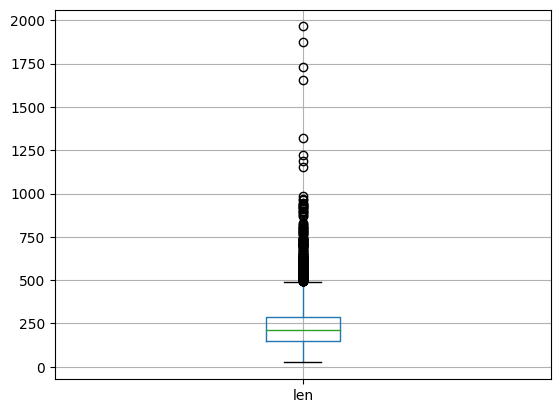

In [5]:
import matplotlib.pyplot as plt
df.boxplot("len")

In [6]:
import re
#split combined triplets into single triplets
new = []
for row in df.iterrows():
    split = re.split("<\w*>", row[1]["label"])[1:] #first one is empty
    for i in range(int(len(split)/3)): #always pairs of 3
        sub = split[i*3:i*3+3]
        new.append([row[1]["text"], sub[0].lstrip().rstrip(), sub[1].lstrip().rstrip(), sub[2].lstrip().rstrip()])

In [7]:
huh = pd.DataFrame(new, columns = ["text", "subj", "obj", "label"])

In [8]:
huh

,text,subj,obj,label
0,11:44pm: UN grain coordinator expects loaded s...,UN grain coordinator,loaded ships,Consult
1,11:44pm: UN grain coordinator expects loaded s...,UN grain coordinator,loaded ships,Consult
2,11:44pm: UN grain coordinator expects loaded s...,UN grain coordinator,loaded ships,Consult
3,"""Russia must clearly understand that Russia wi...",Russia,Russia,Consult
4,8:04pm: Pro-Moscow force renews evacuation of ...,the Kherson region,a counter,Reduce Relations
...,...,...,...,...
11014,"Taiwan's main opposition party the Kuomintang,...",Taiwan's main opposition party,the Kuomintang,Engage In Diplomatic Cooperation
11015,Kanye West hints at another presidential run ...,Kanye West,another presidential run ...,Appeal
11016,Credit:BloombergChina continues to send every ...,Credit,BloombergChina,Provide Aid
11017,Credit:BloombergChina continues to send every ...,Credit,BloombergChina,Provide Aid


In [9]:
huh.text.nunique()

7156

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
cuda_ = "cuda" #all GPUS, specify specific GPUs with "cuda:0"
device = torch.device(cuda_ if torch.cuda.is_available() else "cpu")

nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_model.to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [11]:
probs_l = []
for row in huh.iterrows():
    premise = row[1]["text"]
    subj = row[1]["subj"]
    rel = row[1]["label"]
    obj =  row[1]["obj"]

    hypothesis = f'{subj} does {rel} towards {obj}.'

    # run through model pre-trained on MNLI
    x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                        truncation_strategy='only_first')
    logits = nli_model(x.to(device))[0]

    # we throw away "neutral" (dim 1) and take the probability of
    # "entailment" (2) as the probability of the label being true 
    entail_contradiction_logits = logits[:,[0,2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:,1]

    probs_l.append([row[0], prob_label_is_true.item()])
if device != "cpu": torch.cuda.empty_cache()

/home/werner/thesis_valentin/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2296: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


In [12]:
huh = pd.merge(huh.reset_index(), pd.DataFrame(probs_l, columns = ["index", "prob"]), on = "index")
huh = huh.drop_duplicates(["text", "prob", "label"], keep = "first")

In [13]:
dec = huh[huh.prob < 0.7]
dec.shape

(4959, 6)

In [14]:
keep = huh[huh.prob > 0.7]
keep.shape

(2685, 6)

In [15]:
keep.shape

(2685, 6)

In [20]:
keep.text.nunique()

2601

In [16]:
keep.head(10)

,index,text,subj,obj,label,prob
0,0,11:44pm: UN grain coordinator expects loaded s...,UN grain coordinator,loaded ships,Consult,0.979625
5,5,8:04pm: Pro-Moscow force renews evacuation of ...,which,"70,000 people",Yield,0.979495
6,6,"""Wagner and its alleged boss Yevgeny Prigozhin...",terror,Ukraine,Make Public Statement,0.880736
11,11,Finland and Sweden asked to join the NATO defe...,Finland,the NATO defence alliance,Consult,0.874101
13,13,"In a post on Telegram, Vladimir Saldo, the Rus...",civilians,an additional 15 kilometres,Reduce Relations,0.745262
14,14,the country to hold 5th election in 3 years as...,a powerful new player,a vote,Consult,0.875621
17,17,"The ultranationalist Religious Zionism party, ...",whose provocative top candidate,Arab legislators,Coerce,0.941591
21,21,“Pakistan can serve as the manufacturing base ...,Pakistan,the manufacturing base,Engage In Material Cooperation,0.769296
22,22,In Bangkok for the latest leg of Foreign Affai...,Foreign Affairs Minister Penny Wong,Bangkok,Engage In Diplomatic Cooperation,0.991021
24,24,Prime Minister Han Duck-soo said South Korea's...,Prime Minister Han Duck-soo,South Korea,Make Public Statement,0.741399


In [21]:
res = []
last_txt = ""
for row in keep.iterrows():
    trip = f"<triplet> {row[1]['subj']} <subj> {row[1]['obj']} <obj> {row[1]['label']}"
    if row[1]["text"] == last_txt:
        res[-1] = [res[-1][0], res[-1][1] + trip]
    else:
        res.append([row[1]["text"], trip])
    last_txt = row[1]["text"]

In [22]:
df_new = pd.DataFrame(res, columns = ["text","label"])
df_new.shape

(2601, 2)

In [ ]:
df_new.to_csv("data/out_data/entail_articles_url_coref3.csv.done.csv")

In [23]:
df_new.head()

,text,label
0,11:44pm: UN grain coordinator expects loaded s...,<triplet> UN grain coordinator <subj> loaded s...
1,8:04pm: Pro-Moscow force renews evacuation of ...,"<triplet> which <subj> 70,000 people <obj> Yield"
2,"""Wagner and its alleged boss Yevgeny Prigozhin...",<triplet> terror <subj> Ukraine <obj> Make Pub...
3,Finland and Sweden asked to join the NATO defe...,<triplet> Finland <subj> the NATO defence alli...
4,"In a post on Telegram, Vladimir Saldo, the Rus...",<triplet> civilians <subj> an additional 15 ki...


In [168]:
premise = "In early November, Olaf Scholz will be traveling to Beijing for the first time as German chancellor, and despite the ongoing debate about the German economy’s unsustainable dependence on China, Olaf Scholz will likely bring along a significant delegation of German executives"
subj = "Olaf Scholz"
rel = "Consult"
obj =  "Beijing"

hypothesis = f'{subj} does {rel} towards {obj}.'

# run through model pre-trained on MNLI
x = tokenizer.encode(premise, hypothesis, return_tensors='pt',
                    truncation_strategy='only_first')
logits = nli_model(x)[0]

entail_contradiction_logits = logits[:,[0,2]]
probs = entail_contradiction_logits.softmax(dim=1)
prob_label_is_true = probs[:,1]

prob_label_is_true.item()

0.8752286434173584